# Notebook 4 - Deep Learning Exploration

In this notebook, I implement a DenseNet neural network in PyTorch, offering a deep learning perspective on churn prediction. The focus is on network design, training, and validation.

In [43]:
## Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Turning off warnings
import warnings
warnings.simplefilter('ignore')
## Various libraries for preprocessing, modeling, and evaluation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score

## Utils
import os
import time
from joblib import dump, load

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Read train-validation and holdout datasets
DATASET_READPATH = "/content/drive/MyDrive/quantspark/datasets"
X_train_val = pd.read_csv(os.path.join(DATASET_READPATH,"X_train_val.csv"))
X_hold_out = pd.read_csv(os.path.join(DATASET_READPATH,"X_hold_out.csv"))
y_train_val = pd.read_csv(os.path.join(DATASET_READPATH,"y_train_val.csv")).values.ravel()
y_hold_out = pd.read_csv(os.path.join(DATASET_READPATH,"y_hold_out.csv")).values.ravel()

In [3]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_hold_out_scaled = scaler.transform(X_hold_out)

In [35]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(X_train_val.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc3(x))
        return self.fc4(x) #BCELogits loss format

model = DenseNet().to(device)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled, y_train_val, test_size=0.2, random_state=42)

# Define train, validation and test datasets as TensorDataset
train_data = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device))
val_data = TensorDataset(torch.FloatTensor(X_val).to(device), torch.FloatTensor(y_val).to(device))
test_data = TensorDataset(torch.FloatTensor(X_hold_out_scaled).to(device), torch.FloatTensor(y_hold_out).to(device))

# Define Data Loaders
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [37]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_val), y=y_train_val)
pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Define WEighted Loss and Optimizer
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Training the model and tracking metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
val_roc_aucs = []

model_save_dir = '/content/drive/MyDrive/quantspark/models/nn_models'
best_val_loss = float('inf')
SAVE_PATH_DENSENET = os.path.join(model_save_dir,'best_model_unet_cedice.pth')

# Training the model
for epoch in range(100):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validate every 5 epochs
    if epoch % 5 == 0:
        preds_lst = []
        labels_lst = []

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                val_loss += criterion(outputs.squeeze(), labels).item()
                preds = (outputs.squeeze() > 0.5).float()

                total += labels.size(0)
                correct += (preds == labels).sum().item()

                preds_lst.extend(preds.cpu().numpy())
                labels_lst.extend(labels.cpu().numpy())

        # Validation Metrics
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy_score(labels_lst, preds_lst))
        val_f1_scores.append(f1_score(labels_lst, preds_lst))
        val_precisions.append(precision_score(labels_lst, preds_lst))
        val_recalls.append(recall_score(labels_lst, preds_lst))
        val_roc_aucs.append(roc_auc_score(labels_lst, preds_lst))

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), SAVE_PATH_DENSENET)
            print(f"Saved best model at epoch {epoch}")

        print(f'Epoch {epoch}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracies[-1]:.4f}, F1 Score: {val_f1_scores[-1]:.4f}, ROCAUC Score: {val_roc_aucs[-1]:.4f}')

Saved best model at epoch 1
Epoch 0, Validation Loss: 0.9529, Accuracy: 0.9314, F1 Score: 0.1245, ROCAUC Score: 0.7891
Saved best model at epoch 6
Epoch 5, Validation Loss: 0.8944, Accuracy: 0.8989, F1 Score: 0.1071, ROCAUC Score: 0.8507
Saved best model at epoch 11
Epoch 10, Validation Loss: 0.8594, Accuracy: 0.9506, F1 Score: 0.1856, ROCAUC Score: 0.8480
Epoch 15, Validation Loss: 1.0315, Accuracy: 0.9563, F1 Score: 0.2155, ROCAUC Score: 0.8755
Epoch 20, Validation Loss: 1.0434, Accuracy: 0.9561, F1 Score: 0.2005, ROCAUC Score: 0.8426
Epoch 25, Validation Loss: 1.1935, Accuracy: 0.9476, F1 Score: 0.1878, ROCAUC Score: 0.8752
Epoch 30, Validation Loss: 1.9486, Accuracy: 0.9654, F1 Score: 0.2390, ROCAUC Score: 0.8431
Epoch 35, Validation Loss: 0.9011, Accuracy: 0.9549, F1 Score: 0.1980, ROCAUC Score: 0.8461
Epoch 40, Validation Loss: 1.3933, Accuracy: 0.9674, F1 Score: 0.2564, ROCAUC Score: 0.8564
Epoch 45, Validation Loss: 1.9917, Accuracy: 0.9562, F1 Score: 0.2097, ROCAUC Score: 0.86

KeyboardInterrupt: ignored

Overfitting after epoch 20

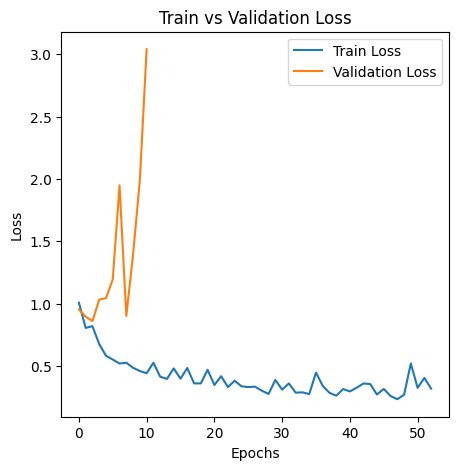

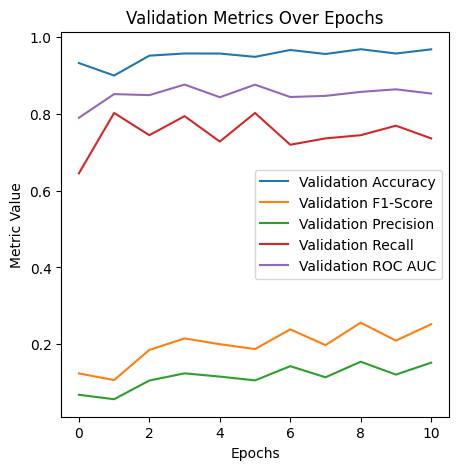

In [45]:
# Plotting Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# Plotting other metrics (Accuracy, F1-Score, etc.)
plt.figure(figsize=(5, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_f1_scores, label='Validation F1-Score')
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.show()

## Holdout Set Predictions

In [46]:
# Load the best saved model
model = DenseNet().to(device)
model.load_state_dict(torch.load(SAVE_PATH_DENSENET))
model.eval()

# Predict on holdout set
holdout_preds = []
holdout_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        holdout_preds.extend(predicted.cpu().numpy())
        holdout_labels.extend(labels.cpu().numpy())

# Evaluation metrics on holdout set
holdout_accuracy = accuracy_score(holdout_labels, holdout_preds)
holdout_f1 = f1_score(holdout_labels, holdout_preds)
holdout_precision = precision_score(holdout_labels, holdout_preds)
holdout_recall = recall_score(holdout_labels, holdout_preds)
holdout_roc_auc = roc_auc_score(holdout_labels, holdout_preds)

print(f'Holdout Set - Accuracy: {holdout_accuracy:.4f}, F1: {holdout_f1:.4f}, Precision: {holdout_precision:.4f}, Recall: {holdout_recall:.4f}, ROC AUC: {holdout_roc_auc:.4f}')

Holdout Set - Accuracy: 0.9536, F1: 0.1698, Precision: 0.0964, Recall: 0.7090, ROC AUC: 0.8321


The model is clearly overfitting and not able to learn the patterns of the dataset. This can be rectified by modifying the neural network architecture, introducing more regularization and trying out different optimizers and loss function. However, due to the time constraints in this assignment, I chose to focus more on the boosting and ensemble models and continue with in the next notebook with their validation, prediction interpretation, risk and error analysis.